###  A twin experiment to test the bed inversion technique of van Pelt et al. (2013). The approach is to first spin a reference glacier up to steady state, then try to reproduce the basal topography based on surface ``observations'' (the reference model). 

# Imports

In [1]:
import icepack, icepack.plot
from firedrake import *
import matplotlib.pyplot as plt
import numpy as np
import tqdm

# Material parameters

In [2]:
from icepack.constants import (
    ice_density as ρ_I,
    water_density as ρ_W,
    gravity as g,
)

T = 255.15 #ice temperature (K)
A = icepack.rate_factor(Constant(T)) #flow parameter (weird icepack units)

# Meshing

In [3]:
Lx, Ly = 10e3, 5e3 #domain length, width in metres
dx, dy = 200, 200 #mesh resolution in metres
nx, ny = int(Lx/dx), int(Ly/dy) #number of nodes

mesh = RectangleMesh(nx, ny, Lx, Ly) #1D mesh defined by number of nodes and domain size
deg = 1 #degree of interpolation functions
Q = FunctionSpace(mesh, 'CG', deg) #function space for interpolating scalars
V = VectorFunctionSpace(mesh, 'CG', deg) #function space for interpolating vectors
x, y = SpatialCoordinate(mesh)
X = np.arange(0, Lx, 1) #for plotting longitudinal profiles
X = np.array([(k, Ly/2) for k in X])

# Design "real-life conditions"

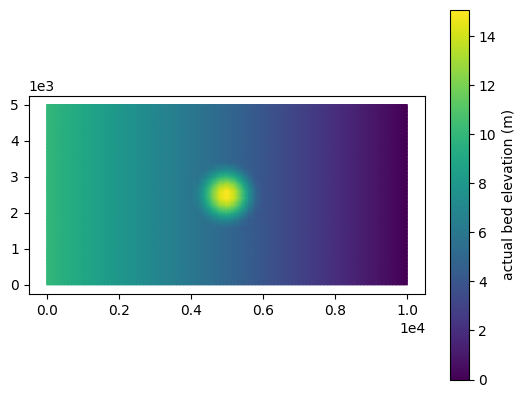

In [4]:
H_0 = 100 #initial thickness (m)
α = -0.001 #basal slope ~ surface slope
bump_height = H_0/10 #amplitude of bedrock bump (m)
bump_R = 1000 #radius of bump (m)

u_x = 10 #upstream velocity (m/a)
smb = Function(Q).project(1 - 2*x/Lx) #surface mass balance (m/a)

###############################
###############################
### create the bedrock bump ###
###############################
###############################

bed = Function(Q).project(α*(x - Lx)) #this fails if bed slope is zero

px, py = Lx/2, Ly/2 #coordinates of the center of the depression
D = conditional(
    sqrt((x - px)**2 + (y - py)**2) < bump_R,  #check if a given coord is within the radius
    1/2 * bump_height * cos(pi * sqrt((x - px)**2 + (y - py)**2) / bump_R) + 1/2 * bump_height,  #and if so, impose the cosine function here
    0  #else, zero outside the radius
)

bed.project(bed + D) #adjust the bed
s = Function(Q).project(bed + H_0) 
H = Function(Q).project(Constant(H_0))


############
############
### plot ###
############
############

fig, axes = icepack.plot.subplots()
colors = firedrake.tripcolor(bed, axes=axes)
fig.colorbar(colors, label = 'actual bed elevation (m)')

# Model initialization

In [5]:
u = Function(V).project(as_vector((u_x, 0)))
τ_D = Function(Q).project(-ρ_I*g*H*α) #driving stress of an ice stream (ish)
μ_b = Function(Q).project(τ_D/(u_x**(1/3))) #assume weertman friction coefficient is 3
μ_s = Constant(0.00) #sidewall friction coefficient

inflow_ids = [1]
sidewall_ids = [3, 4] #+/- y boundaries are free-slip sidewalls in this simulation

opts = {
    'dirichlet_ids': inflow_ids, 
    'side_wall_ids': sidewall_ids,
}

model = icepack.models.IceStream(friction = icepack.models.friction.bed_friction, side_friction = icepack.models.friction.side_friction)
solver = icepack.solvers.FlowSolver(model, **opts)

# Spin "real" glacier up to steady state

100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:20<00:00,  9.97it/s]


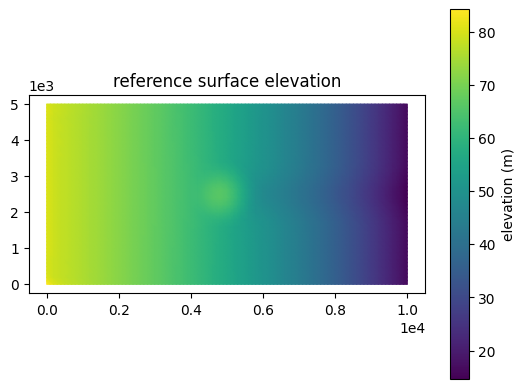

In [6]:
Δt = 1/2
num_years = 100
num_timesteps = int(num_years/Δt)

for step in tqdm.trange(num_timesteps):

    u = solver.diagnostic_solve(
        velocity = u, thickness = H, surface = s, fluidity = A, friction = μ_b, side_friction = μ_s
    )

    H = solver.prognostic_solve(
        Δt, thickness = H, accumulation = smb, velocity = u, thickness_inflow = H
    )

    s = icepack.compute_surface(thickness = H, bed = bed)
    τ_D.project(-ρ_I*g*H*α) #driving stress
    μ_b.project(τ_D/(u_x**(1/3))) #weertman friction coefficient

fig, axes = icepack.plot.subplots()
colors = firedrake.tripcolor(s, axes=axes)
fig.colorbar(colors, label = 'elevation (m)')
axes.set_title('reference surface elevation');

# Try to recover the correct bed topography

In [7]:
s_ref = s.copy(deepcopy = True)

bed_guess = Function(Q).project(α*(x - Lx)) #assume we have a decent-ish idea of underlying bed slope, just not the bump
s_guess = Function(Q).project(bed_guess + H_0)
H_guess = Function(Q).project(s_guess - bed_guess)
u_guess = Function(V).project(as_vector((u_x, 0))) #assume we know the velocity well enough to at least guess a boundary condition

τ_D_guess = Function(Q).project(-ρ_I*g*H_guess*α) #driving stress
μ_b_guess = Function(Q).project(τ_D_guess/(u_x**(1/3))) #assume weertman friction coefficient is 3

bed_evolution = []
surface_evolution = []
bed_iteration_result = bed_guess.at(X, tolerance = 1e-10)
bed_evolution.append(bed_iteration_result)

K = 1/10

In [8]:
num_iterations = 50

for iteration in tqdm.trange(num_iterations):

    bed_mod = bed_guess.copy(deepcopy = True) #this updates each iteration
    H_mod = Function(Q).project(s_guess - bed_mod) #and therefore this does as well
    τ_D_mod = Function(Q).project(-ρ_I*g*H_mod*α) #etc
    μ_b_mod = Function(Q).project(τ_D_mod/(u_x**(1/3))) #etc
    
    s_mod = s_guess.copy(deepcopy = True) #but reset this
    u_mod = u_guess.copy(deepcopy = True) #and this

    Δt = 1/2
    num_years = 100
    num_timesteps = int(num_years/Δt)

    for step in range(num_timesteps):

        u_mod = solver.diagnostic_solve(
            velocity = u_mod, thickness = H_mod, surface = s_mod, fluidity = A, friction = μ_b_mod, side_friction = μ_s
        )
    
        H_mod = solver.prognostic_solve(
            Δt, thickness = H_mod, accumulation = smb, velocity = u_mod, thickness_inflow = H_mod
        )
        
        s_mod = icepack.compute_surface(thickness = H_mod, bed = bed_mod)
        τ_D_mod.project(-ρ_I*g*H_mod*α) #driving stress
        μ_b_mod.project(τ_D_mod/(u_x**(1/3))) #weertman friction coefficient

    bed_guess.project(bed_mod - K*(s_mod - s_ref))
    bed_iteration_result = bed_guess.at(X, tolerance = 1e-10)
    surface_iteration_result = s_mod.at(X, tolerance = 1e-10)
    bed_evolution.append(bed_iteration_result)
    surface_evolution.append(surface_iteration_result)

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [18:03<00:00, 21.67s/it]


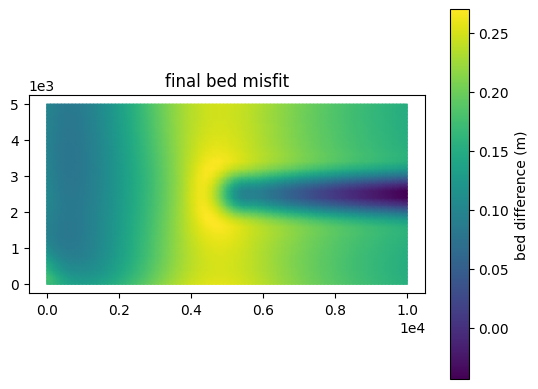

In [9]:
bed_misfit = Function(Q).project((bed_guess - bed))

fig, axes = icepack.plot.subplots()
colors = firedrake.tripcolor(bed_misfit, axes=axes)
fig.colorbar(colors, label = 'bed difference (m)')
axes.set_title('final bed misfit');

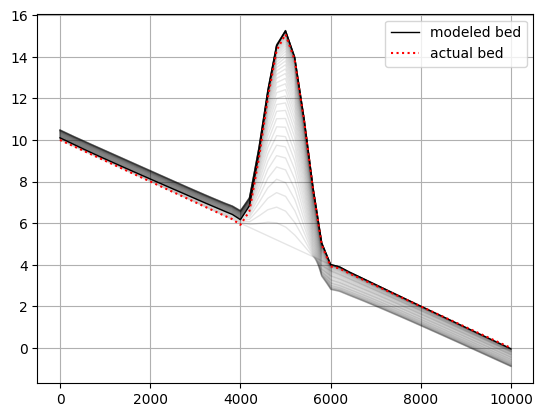

In [10]:
reference_line = bed.at(X, tolerance = 1e-10)
plt.figure()
plt.plot(bed_guess.at(X, tolerance = 1e-10), color = 'k', linestyle = 'solid', linewidth = 1, label = 'modeled bed')
for i in range(len(bed_evolution)):
    plt.plot(bed_evolution[i], color = 'k', linestyle = 'solid', linewidth = 1, alpha = 0.1)
plt.plot(reference_line, color = 'red', linestyle = 'dotted', label = 'actual bed')
plt.grid()
plt.legend()
plt.show()